# Universal noise

This notebook computes a universal noise pattern, which can be added to any image 
and missleads the open pose network 

In [1]:
%load_ext autoreload
%autoreload 2
# imports
import datetime
import logging
import os
import pathlib
import sys

import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns


from loss_functions import multi_stage_loss
from plot_utils import gen_plot_universal_noise, plot_pose
from tf_pose import common
from tf_pose.common import CocoPart
from tf_pose.estimator import TfPoseEstimator, PoseEstimator
from tf_pose.networks import get_graph_path
from utils import load_batch, pose_loss_single_human, compare_poses, get_image_transform_mask
from PIL import Image
import glob 
import wandb
import random
from run_config import Run_types, Run_settings

sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('../..'))


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger('TfPoseEstimatorRun').setLevel(logging.ERROR)
logging.getLogger('DeepExplain').setLevel(logging.ERROR)
logging.getLogger('TfPoseEstimator').setLevel(logging.ERROR)
logging.getLogger("wandb").setLevel(logging.ERROR)
random.seed(42)

Using tf version = 1.13.1


In [2]:
# run config
IMAGE_WIDTH, IMAGE_HEIGHT = 432, 368
NOISE_WIDTH, NOISE_HEIGHT = 200, 400
RESIZE_OUT_RATIO = 2.0


In [3]:
# the input image
sample_tensor = tf.placeholder(
    tf.float32,
    shape=(None, None, None, 3),
    name='sample'
)

# the current universal noise
universal_noise_tensor = tf.placeholder(
    tf.float32,
    shape=(None, None, None, 3),
    name='universal_noise'
)

# create a placeholder for the transform
transforms_tensor = tf.placeholder(
    tf.float32,
    shape=(None, 8),
    name='2d_transform'
)

mask_tensor = tf.placeholder(
    tf.bool,
    shape=(None, None, None, 3),
    name='mask'
)

# warp the noise 
warped_universal_noise_tensor = tf.contrib.image.transform(
    universal_noise_tensor,
    transforms_tensor,
    #interpolation='NEAREST',
    interpolation='BILINEAR',
    output_shape=(IMAGE_HEIGHT, IMAGE_WIDTH),
    name='warped_universal_noise'
)


ax_input_overwrite_tensor = tf.where(
    mask_tensor,
    warped_universal_noise_tensor,
    sample_tensor,
    name='ax_input_overwrite'
)

In [4]:
estimator = TfPoseEstimator(
    get_graph_path('cmu'), 
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT), 
    trt_bool=False, input_overwrite_tensor=ax_input_overwrite_tensor, sample_image=sample_tensor)
UPSAMPLE_SIZE = np.array([int(estimator.target_size[1] / 8 * RESIZE_OUT_RATIO),
                 int(estimator.target_size[0] / 8 * RESIZE_OUT_RATIO)])

In [13]:
def wandb_init(name):
    run = wandb.init(
        project = "2d_warp_universal_noise", 
        reinit = True,
        name = name,
        config={
            "epochs": 5,
            "epsilon": 5000,
            "upsample_size_0": UPSAMPLE_SIZE[0],
            "upsample_size_1": UPSAMPLE_SIZE[1],
            "batch_size": 16,
            "image_width": IMAGE_WIDTH,
            "image_height": IMAGE_HEIGHT,
            "noise_width": NOISE_WIDTH,
            "noise_height": NOISE_HEIGHT,
        }
    )
    
    return run 

def load_batch_with_transform(image_targets, image_masks, image_transforms, start_index, batch_size):
    i = start_index
    batch_image = []
    batch_mask = []
    batch_transform = []
    while len(batch_image) < batch_size:
        if i >= len(image_targets):
            i = 0
        batch_image.append(image_targets[i])
        batch_mask.append(image_masks[i])
        batch_transform.append(image_transforms[i])
        i += 1
    return np.asarray(batch_image), np.asarray(batch_mask), np.asarray(batch_transform), i

def get_universal_noise(run_settings, estimator, image_targets, masks, transforms):
    cur_run = wandb_init(f'{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}_run')
    with cur_run:
        upsample_size = [cur_run.config.upsample_size_0, cur_run.config.upsample_size_0]

        # get all outputs as np matrix
        target_np_heat = np.zeros((cur_run.config.batch_size, 46, 54, 19))
        target_np_paf = np.zeros((cur_run.config.batch_size, 46, 54, 38))

        # where does the current batch start
        training_stats = {
            'gobal_step': 0,
            'batch_index': 0,
            'universal_noise': np.zeros((NOISE_HEIGHT, NOISE_WIDTH, 3)),
            'file_name': SNAPSHOT_NAME
        }

        target_heat = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 19))
        target_paf = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 38))
        grad_func, loss_func = run_settings.get_loss(
            estimator, 
            target_heat, 
            target_paf, 
            universal_noise_tensor)

        
        steps = len(image_targets) // cur_run.config.batch_size
        

        ### ================= TRAINING ================= ###
        for epoch in range(cur_run.config.epochs):
            print(f"run {epoch + 1}/{cur_run.config.epochs}")
            for step in tqdm(range(steps)):
                (batch_image, 
                 batch_mask, 
                 batch_transform, 
                 training_stats['batch_index']
                ) = load_batch_with_transform(
                    train_image_targets, 
                    train_image_masks,
                    train_image_transforms,
                    training_stats['batch_index'], 
                    cur_run.config.batch_size
                )
                
                repeated_noise = np.repeat(np.expand_dims(
                    training_stats['universal_noise'], axis=0), cur_run.config.batch_size, 0)


                feed_dict = {
                    # the target heatmap
                    target_heat: target_np_heat,
                    # the target paf
                    target_paf: target_np_paf,
                    # the current sample images
                    sample_tensor: batch_image,
                    # the current universal noise
                    universal_noise_tensor: repeated_noise,
                    # the current 2d warp
                    transforms_tensor: batch_transform,
                    # the upsample size
                    estimator.upsample_size: upsample_size,
                    mask_tensor: batch_mask
                }


                gradient, loss = estimator.persistent_sess.run(
                    [grad_func, loss_func],
                    feed_dict=feed_dict
                )
                

                wandb.log({'loss': loss}, step=training_stats['gobal_step'])

                if step % 100 == 0:
                    # save universal noise
                    np.save(training_stats['file_name'], training_stats['universal_noise'])
                    wandb.log({
                        'universal_noise': wandb.Image(
                            np.clip(training_stats['universal_noise'], 0, 255), 
                            caption='universal noise'
                        )
                    }, step=training_stats['gobal_step'])

                ### ================= UPDATE STEP ================= ###
                scaled_gradient = (cur_run.config.epsilon * gradient)            

                training_stats['universal_noise'] = training_stats['universal_noise'] - scaled_gradient
                training_stats['universal_noise'] = np.clip(training_stats['universal_noise'], 0, 255)
                training_stats['gobal_step'] += 1


    return training_stats['universal_noise']

In [14]:
### TOTAL RUN ###
universal_noises = []
for run_type in Run_types:        
    print(f"Running: {run_type.name}")
    
    run_settings = Run_settings(run_type)
    train_dir, test_dir, SNAPSHOT_NAME = run_settings.get_settings()
    print(f"train_dir={train_dir}")
    print(f"test_dir={test_dir}")
    print(f"SNAPSHOT_NAME={SNAPSHOT_NAME}")

    [train_image_path_targets, 
     train_image_targets, 
     train_image_masks, 
     train_image_transforms] = get_image_transform_mask(train_dir, IMAGE_WIDTH, IMAGE_HEIGHT)


    print(f'Found {len(train_image_path_targets)} train images')

    universal_noise = get_universal_noise(
            run_settings,
            estimator, 
            train_image_targets, 
            train_image_masks, 
            train_image_transforms
        )
    universal_noises.append(universal_noise)

Running: all_heat_paf_loss_bilinear
train_dir=../data/generated/train
test_dir=../data/generated/test
SNAPSHOT_NAME=../snapshots/universal_noise_with_warp_bilinear.npy
Found 1800 train images


  0%|          | 0/112 [00:00<?, ?it/s]

run 1/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 2/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 3/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 4/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 5/5


100%|██████████| 112/112 [01:39<00:00,  1.13it/s]


Running: same_distance_heat_paf_loss_bilinear
train_dir=../data/sameDistance/train
test_dir=../data/sameDistance/test
SNAPSHOT_NAME=../snapshots/universal_noise_with_warp_same_distance_bilinear.npy
Found 1800 train images


  0%|          | 0/112 [00:00<?, ?it/s]

run 1/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 2/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 3/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 4/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 5/5


100%|██████████| 112/112 [01:42<00:00,  1.09it/s]


Running: same_roation_heat_paf_loss_bilinear
train_dir=../data/sameRotation/train
test_dir=../data/sameRotation/test
SNAPSHOT_NAME=../snapshots/universal_noise_with_warp_same_rotation_bilinear.npy
Found 1800 train images


  0%|          | 0/112 [00:00<?, ?it/s]

run 1/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 2/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 3/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 4/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 5/5


100%|██████████| 112/112 [01:40<00:00,  1.12it/s]


Running: same_distance_roation_heat_paf_loss_bilinear
train_dir=../data/sameRotationDistance/train
test_dir=../data/sameRotationDistance/test
SNAPSHOT_NAME=../snapshots/universal_noise_with_warp_same_rotation_distance_bilinear.npy
Found 1800 train images


  0%|          | 0/112 [00:00<?, ?it/s]

run 1/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 2/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 3/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 4/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 5/5


100%|██████████| 112/112 [01:39<00:00,  1.12it/s]


Running: all_paf_loss_bilinear
train_dir=../data/generated/train
test_dir=../data/generated/test
SNAPSHOT_NAME=../snapshots/universal_noise_with_warp_PAF_bilinear.npy
Found 1800 train images


  0%|          | 0/112 [00:00<?, ?it/s]

run 1/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 2/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 3/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 4/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 5/5


100%|██████████| 112/112 [01:34<00:00,  1.19it/s]


Running: same_distance_paf_loss_bilinear
train_dir=../data/sameDistance/train
test_dir=../data/sameDistance/test
SNAPSHOT_NAME=../snapshots/universal_noise_with_warp_same_distance_PAF_bilinear.npy
Found 1800 train images


  0%|          | 0/112 [00:00<?, ?it/s]

run 1/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 2/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 3/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 4/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 5/5


100%|██████████| 112/112 [01:37<00:00,  1.15it/s]


Running: same_roation_paf_loss_bilinear
train_dir=../data/sameRotation/train
test_dir=../data/sameRotation/test
SNAPSHOT_NAME=../snapshots/universal_noise_with_warp_same_rotation_PAF_bilinear.npy
Found 1800 train images


  0%|          | 0/112 [00:00<?, ?it/s]

run 1/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 2/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 3/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 4/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 5/5


100%|██████████| 112/112 [01:33<00:00,  1.20it/s]


Running: same_distance_roation_paf_loss_bilinear
train_dir=../data/sameRotationDistance/train
test_dir=../data/sameRotationDistance/test
SNAPSHOT_NAME=../snapshots/universal_noise_with_warp_same_rotation_distance_PAF_bilinear.npy
Found 1800 train images


  0%|          | 0/112 [00:00<?, ?it/s]

run 1/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 2/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 3/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 4/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 5/5


100%|██████████| 112/112 [01:33<00:00,  1.20it/s]


In [6]:
### SINGLE RUN ###
SINGLE_RUN_TYPE = Run_types.same_distance_heat_paf_loss_bilinear
run_settings = Run_settings(SINGLE_RUN_TYPE)
train_dir, test_dir, SNAPSHOT_NAME = run_settings.get_settings()
print(f"train_dir={train_dir}")
print(f"test_dir={test_dir}")
print(f"SNAPSHOT_NAME={SNAPSHOT_NAME}")

[train_image_path_targets, 
 train_image_targets, 
 train_image_masks, 
 train_image_transforms] = get_image_transform_mask(train_dir, IMAGE_WIDTH, IMAGE_HEIGHT)


print(f'Found {len(train_image_path_targets)} train images')

universal_noise = get_universal_noise(
        run_settings,
        estimator, 
        train_image_targets, 
        train_image_masks, 
        train_image_transforms
    )

train_dir=../data/sameRotation/train
test_dir=../data/sameRotation/test
SNAPSHOT_NAME=../snapshots/universal_noise_with_warp_same_rotation_interpolation.npy
Found 1800 train images


  0%|          | 0/112 [00:00<?, ?it/s]

run 1/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 2/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 3/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 4/5


  0%|          | 0/112 [00:00<?, ?it/s]

run 5/5


100%|██████████| 112/112 [01:42<00:00,  1.09it/s]


(400, 200, 3)
float64


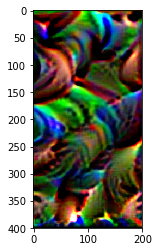

In [7]:
run_settings = Run_settings(SINGLE_RUN_TYPE)
train_dir, test_dir, SNAPSHOT_NAME = run_settings.get_settings()
universal_noise = np.load(SNAPSHOT_NAME)
print(universal_noise.shape)
print(universal_noise.dtype)
universal_noise_image = Image.fromarray(universal_noise.astype(np.uint8))
b, g, r = universal_noise_image.split()
universal_noise_image = Image.merge("RGB", (r, g, b))
plt.imshow(universal_noise_image)

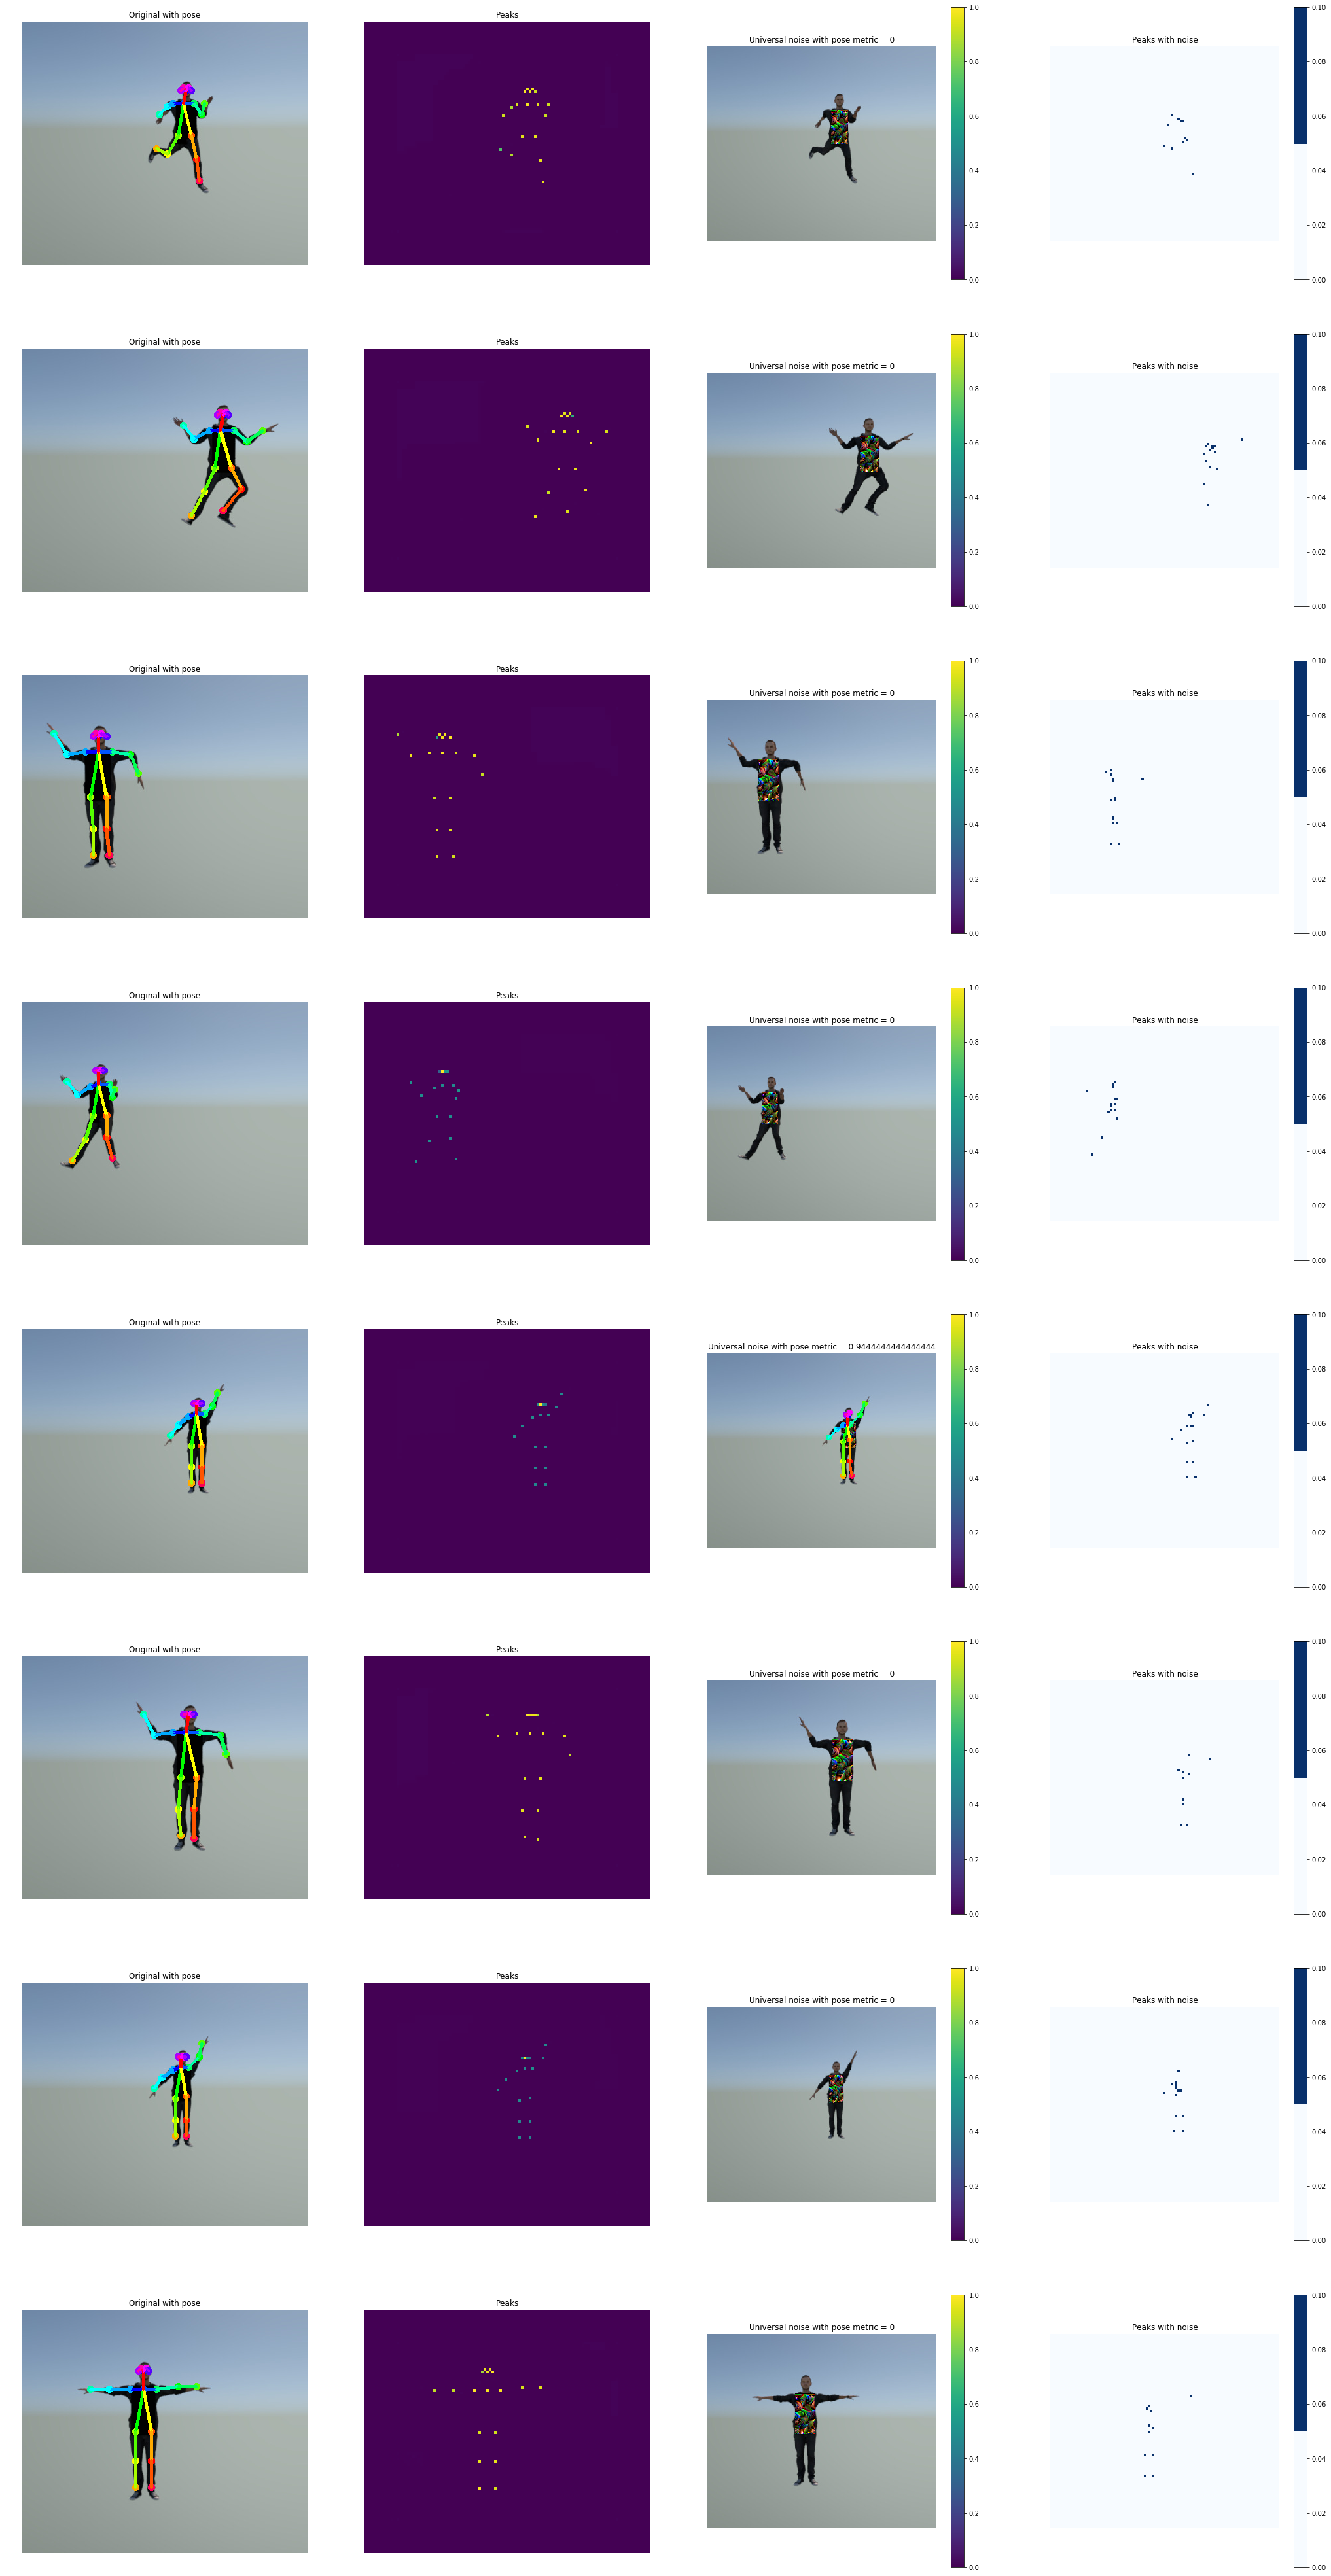

In [8]:
# Plot attributions
%matplotlib inline

[test_image_path_targets, 
 test_image_targets, 
 test_image_masks, 
 test_image_transforms] = get_image_transform_mask(test_dir, IMAGE_WIDTH, IMAGE_HEIGHT)

test_batch_size = 8
test_batch_start = 0
(test_batch_image, 
 test_batch_mask, 
 test_batch_transform, 
 _
) = load_batch_with_transform(
    test_image_targets, 
    test_image_masks,
    test_image_transforms,
    test_batch_start,
    test_batch_size
)

n_cols = 4
n_rows = len(test_batch_image)
fig_scale = 3
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(
    3*n_cols*fig_scale, 3*n_rows*fig_scale))

plot_cnt = 0

universal_noise_image = Image.fromarray(universal_noise.astype(np.uint8))
b, g, r = universal_noise_image.split()
universal_noise_image = Image.merge("RGB", (r, g, b))


for i, xi in enumerate(test_batch_image):
    detections = estimator.inference(xi, resize_to_default=True, upsample_size=RESIZE_OUT_RATIO)
    detections_result = TfPoseEstimator.draw_humans(xi, detections, imgcopy=True)
    
    ax = axes.flatten()[plot_cnt]
    ax.imshow(cv2.cvtColor(detections_result, cv2.COLOR_BGR2RGB))
    ax.set_title(f'Original with pose')
    ax.axis('off')
    plot_cnt += 1
    
    # compute peaks
    peaks = np.sum(estimator.peaks[:, :, :18], axis=2)
    ax = axes.flatten()[plot_cnt]
    ax.imshow(peaks)
    ax.set_title(f'Peaks')
    ax.axis('off')
    plot_cnt += 1
    
    
    transforms = [test_batch_transform[i]]

    detections_noise = estimator.inference(
        xi, 
        resize_to_default=True, 
        upsample_size=RESIZE_OUT_RATIO, 
        transforms=transforms,
        universal_noise=[universal_noise],
        mask=[test_batch_mask[i]]
    )
    detections_result_noise = estimator.draw_humans_warped(
        [xi], 
        detections_noise, 
        [universal_noise], 
        transforms, 
        [test_batch_mask[i]])
    
    metric = pose_loss_single_human(detections_noise, detections)
    
    ax = axes.flatten()[plot_cnt]
    heat_image = ax.imshow(cv2.cvtColor(np.clip(detections_result_noise, 0, 255), cv2.COLOR_BGR2RGB) / 255.0)
    ax.set_title(f'Universal noise with pose metric = {metric}')
    ax.axis('off')
    fig.colorbar(heat_image, ax=ax, shrink=1.0)
    plot_cnt += 1
    
    # compute peaks
    peaks = np.sum(estimator.peaks[:, :, :18], axis=2)
    ax = axes.flatten()[plot_cnt]
    heat_image = ax.imshow(peaks, cmap=plt.cm.get_cmap('Blues', 2), vmin=0, vmax=0.1)
    ax.set_title(f'Peaks with noise')
    ax.axis('off')
    fig.colorbar(heat_image, ax=ax, shrink=1.0)
    plot_cnt += 1
    

In [9]:
error_values = []
# compute total error metric 
for image, mask, transform in tqdm(zip(test_image_targets, test_image_masks, test_image_transforms), total=len(test_image_targets)):
    detections = estimator.inference(image, resize_to_default=True, upsample_size=RESIZE_OUT_RATIO)
    
    detections_noise = estimator.inference(
        image, 
        resize_to_default=True, 
        upsample_size=RESIZE_OUT_RATIO, 
        transforms=[transform],
        universal_noise=[universal_noise],
        mask=[mask]
    )
    error_values.append(pose_loss_single_human(detections_noise, detections))

100%|██████████| 200/200 [00:25<00:00,  7.77it/s]


In [10]:
print(np.mean(error_values))

0.0653329248366013


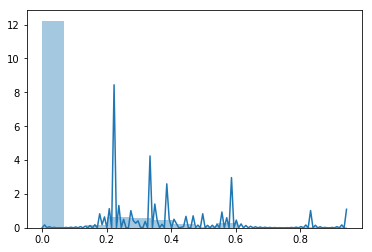

In [11]:
sns.distplot(error_values)

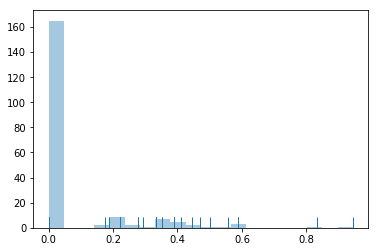

In [12]:
sns.distplot(error_values, bins=20, kde=False, rug=True);